# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [971]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
#!kaggle datasets download -d khaledzsa/traffic-dataset

#!unzip traffic-dataset.zip

In [972]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt


# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM

In [973]:
import pandas as pd 
df = pd.read_csv("Traffic Data.csv")
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [974]:
df['date_time']=pd.to_datetime(df['date_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [975]:
for column in df.columns:
    print(f"{column}: {df[column].unique()}")

for column in df.columns:
    df[column] = df[column].replace('na', np.nan)
    
    if df[column].isnull().sum() > 0: 
        most_frequent = df[column].mode()[0]
        df[column] = df[column].fillna(most_frequent)

for column in df.columns:
    print(f"{column}: {df[column].unique()}")


df


traffic_volume: [1209. 1248. 4602. ... 6742. 1783. 1132.]
temp: [291.15 286.01 293.69 ... 249.88 269.23 289.06]
rain_1h: [ 0.    0.25  1.78  2.79  0.44  2.26  0.28  1.86  1.02  4.    0.89  9.62
  5.08  1.15  3.05  3.45  2.85  4.79  1.82  5.42  1.85  5.19  2.62  1.52
  0.85  0.38  0.76  1.27  2.54 10.6   0.51  2.86  0.34  2.29  1.01  2.03
  2.16  1.1   3.1   3.94  5.84  0.69  1.14  1.4   1.66  1.68  3.4   2.48
  0.93  1.06  4.15  2.2   2.41  2.76  0.86  0.8   1.6   0.42  0.71  4.06
  0.61  0.81  0.43  0.98  1.72  1.21  7.11  0.3   2.88  0.29  0.32  2.61
  1.3   5.12  0.63  1.45  5.62  0.35  0.64  3.18  2.92  2.6   2.96  4.74
  1.65  3.3   0.66]
snow_1h: [0.]
clouds_all: [90  1 75  5 40 20  0  8 88 68 92 44 48 32 12 36 80 24 64 76 56]
weather_main: ['Mist' 'Clear' 'Clouds' 'Rain' 'Thunderstorm' 'Fog' 'Drizzle' 'Snow'
 'Haze' 'Smoke']
weather_description: ['mist' 'sky is clear' 'broken clouds' 'moderate rain'
 'proximity shower rain' 'proximity thunderstorm' 'fog' 'light rain'
 'overcast 

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [976]:
df.dtypes

traffic_volume                float64
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
dtype: object

In [977]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['weather_main'] = le.fit_transform(df['weather_main'])
df['weather_description'] = le.fit_transform(df["weather_description"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       20000 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  int32         
 6   weather_description  20000 non-null  int32         
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int32(2), int64(1)
memory usage: 1.1 MB


In [978]:
df.isnull().sum()

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
dtype: int64

In [979]:
tr_col = "traffic_volume"
series = df[tr_col]
series.head()

0    1209.0
1    1248.0
2    4602.0
3    2838.0
4    5794.0
Name: traffic_volume, dtype: float64

In [980]:
df.drop_duplicates(inplace=True)

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [981]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,5,16,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,0,25,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,1,1,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,0,25,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,0,25,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,1,23,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,1,23,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,0,25,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,1,1,2018-02-12 15:00:00


In [982]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
count,19988.000000,19988.000000,19988.000000,19988.0,19988.000000,19988.000000,19988.000000,19988
mean,3275.071093,281.161855,0.048425,0.0,49.390184,2.759856,16.483740,2017-10-22 05:11:46.023614208
min,113.000000,243.390000,0.000000,0.0,0.000000,0.000000,0.000000,2016-11-18 15:00:00
25%,1223.000000,271.950000,0.000000,0.0,1.000000,0.000000,12.000000,2017-04-30 14:00:00
50%,3426.000000,281.825000,0.000000,0.0,75.000000,1.000000,17.000000,2017-10-21 08:00:00
75%,4927.000000,291.830000,0.000000,0.0,90.000000,5.000000,25.000000,2018-04-13 21:00:00
max,16781.000000,310.070000,10.600000,0.0,92.000000,9.000000,33.000000,2018-09-30 23:00:00
std,1978.432149,12.660808,0.398124,0.0,39.645747,2.822170,8.070733,NaN


In [983]:
df.dtypes

traffic_volume                float64
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                    int32
weather_description             int32
date_time              datetime64[ns]
dtype: object

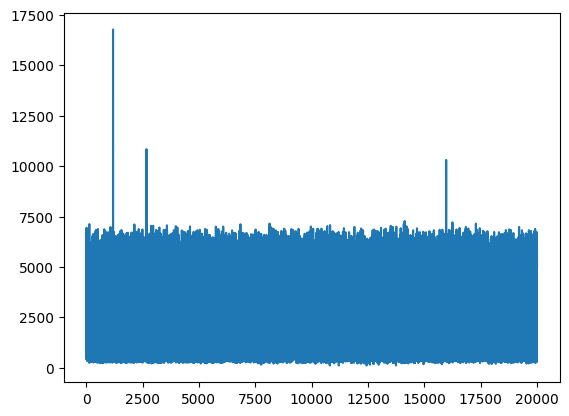

In [984]:

plt.plot(series)

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [985]:
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    df = df[~((df[column] < lower_bound) | (df[column] > upper_bound))]
df.shape


(19273, 8)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e514671250>,
 'caps': [<matplotlib.lines.Line2D at 0x1e514672840>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e5124d3a40>],
 'medians': [<matplotlib.lines.Line2D at 0x1e514672db0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e514673020>],
 'means': []}

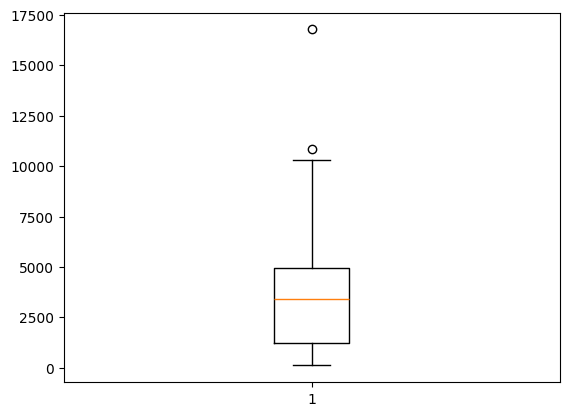

In [986]:
plt.boxplot(series)

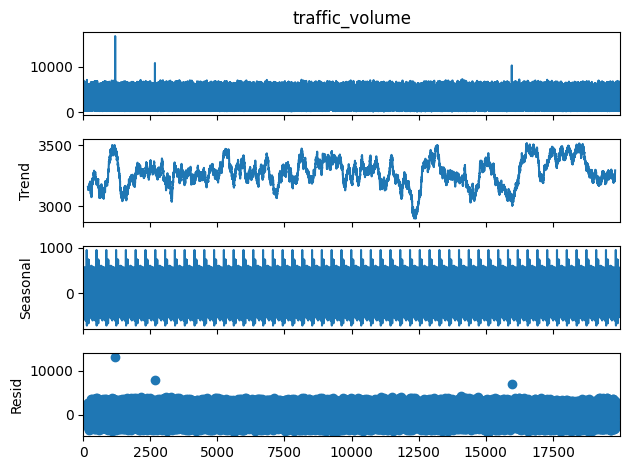

In [987]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = series.dropna()
result = seasonal_decompose(series,model='additive',period=365)
result.plot()
plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [1019]:
df["traffic_volume"] = df['traffic_volume'].shift(1)

In [1021]:
df['date_time'] = pd.to_datetime(df['date_time'])
df['day_of_week'] = df['date_time'].dt.dayofweek
df['day_of_year'] = df['date_time'].dt.dayofyear
df['month'] = df['date_time'].dt.month

df['traffic_volume'] = df['traffic_volume'].fillna =(df['traffic_volume'].mean())
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,day_of_week,day_of_year,month
0,10309.0,291.15,0.0,0.0,90,5,16,2017-08-27 01:00:00,6,239,8
1,10309.0,286.01,0.0,0.0,1,0,25,2018-09-06 23:00:00,3,249,9
2,10309.0,293.69,0.0,0.0,75,1,1,2017-08-25 18:00:00,4,237,8
3,10309.0,262.35,0.0,0.0,1,0,25,2017-11-09 22:00:00,3,313,11
4,10309.0,267.08,0.0,0.0,5,0,25,2017-11-09 15:00:00,3,313,11


In [1022]:
df.drop(['rain_1h','snow_1h'],axis=True)

,traffic_volume,temp,clouds_all,weather_main,weather_description,date_time,day_of_week,day_of_year,month
0,10309.0,291.15,90,5,16,2017-08-27 01:00:00,6,239,8
1,10309.0,286.01,1,0,25,2018-09-06 23:00:00,3,249,9
2,10309.0,293.69,75,1,1,2017-08-25 18:00:00,4,237,8
3,10309.0,262.35,1,0,25,2017-11-09 22:00:00,3,313,11
4,10309.0,267.08,5,0,25,2017-11-09 15:00:00,3,313,11
...,...,...,...,...,...,...,...,...,...
19995,10309.0,296.42,40,1,23,2018-06-06 21:00:00,2,157,6
19996,10309.0,285.58,40,1,23,2017-10-25 15:00:00,2,298,10
19997,10309.0,275.30,1,0,25,2018-03-28 23:00:00,2,87,3
19998,10309.0,260.94,75,1,1,2018-02-12 15:00:00,0,43,2


[[<matplotlib.axis.XTick at 0x1e51ed7ebd0>,
 [Text(0, 0, 'Sun'),
  Text(24, 0, 'Mon'),
  Text(48, 0, 'Tue'),
  Text(72, 0, 'Wed'),
  Text(96, 0, 'Thu'),
  Text(120, 0, 'Fri'),
  Text(144, 0, 'Sat')]]

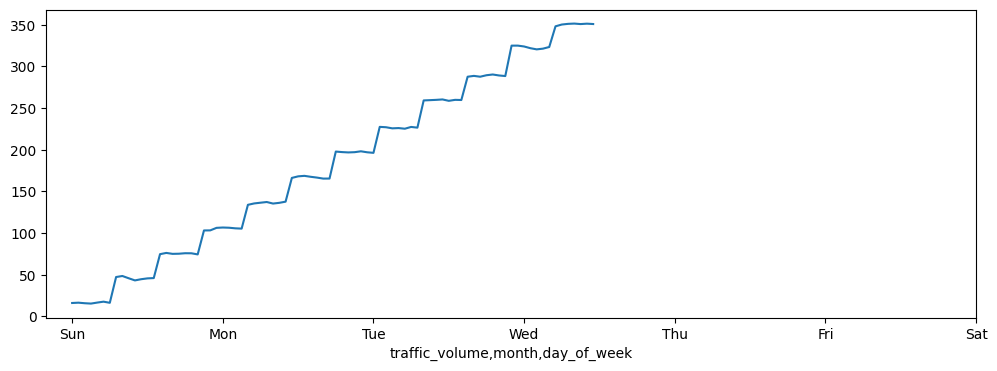

In [1023]:
fig, ax = plt.subplots(figsize=(12, 4))
df1= df.groupby(["traffic_volume", "month",'day_of_week'])["day_of_year"].mean()
df1.plot(ax=ax)
ax.set(
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
)


In [992]:
series

0        1209.0
1        1248.0
2        4602.0
3        2838.0
4        5794.0
          ...  
19995    2723.0
19996    5895.0
19997    1132.0
19998    5525.0
19999    5042.0
Name: traffic_volume, Length: 20000, dtype: float64

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [1031]:
from sklearn.preprocessing import MaxAbsScaler
values_to_scale = df['traffic_volume'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values_to_scale)


In [1032]:
train_size = int(len(scaled_data) * 0.9)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [1026]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [1033]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(17285, 60, 1)
(17285,)
(1868, 60, 1)
(1868,)


(None, None)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [1034]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential()

model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.summary()

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [1042]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=100,
          verbose=1,
          callbacks= [ early_stopping])

Epoch 1/100


: 

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
train_predict =scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 3272.899169921875
Test RMSE: 3272.899169921875


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
look_back = 30

trainPredictPlot = np.empty_like(df)
trainPredictPlot[:] = np.nan

trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

testPredictPlot = np.empty_like(df,dtype=float)
testPredictPlot[:] = np.nan

test_start = len(df) - len(test_predict)

testPredictPlot[test_start:] = test_predict

original_scaled_data = scaler.inverse_transform(scaled_data)


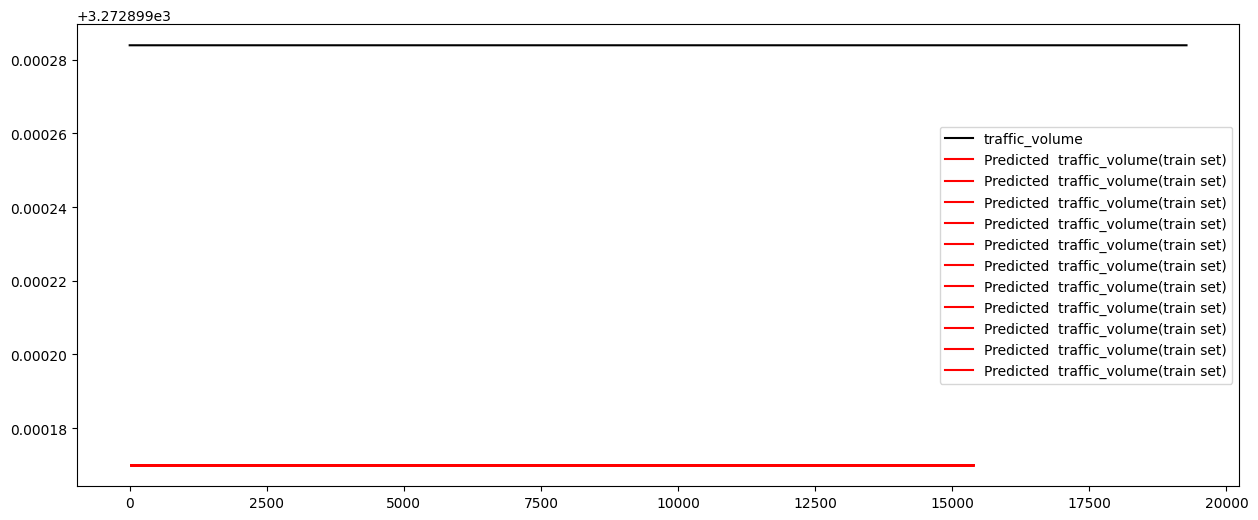

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"traffic_volume")
plt.plot(trainPredictPlot, color='red', label=f"Predicted  traffic_volume(train set)")
plt.legend()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU

model = Sequential([
    GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  
    Dropout(0.2),
    GRU(units=64, return_sequences=True),
    Dropout(0.2),
    GRU(units=32, return_sequences=True),
    Dropout(0.2),
    GRU(units=16),
    Dropout(0.2),
    Dense(1)
])
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_44 (GRU)                    │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ (None, 60, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_46 (GRU)                    │ (None, 60, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_47 (GRU)                    │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,377 (388.19 KB)

 Trainable params: 99,377 (388.19 KB)

 Non-trainable params: 0 (0.00 B)

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=100,
          verbose=1,
          callbacks= [ early_stopping])

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100
 32/154 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0000e+00

KeyboardInterrupt: 

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

480/480 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
train_predict =scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 3272.899169921875
Test RMSE: 3272.899169921875


In [ ]:
look_back = 30

trainPredictPlot = np.empty_like(df)
trainPredictPlot[:] = np.nan

trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

testPredictPlot = np.empty_like(df,dtype=float)
testPredictPlot[:] = np.nan

test_start = len(df) - len(test_predict)

testPredictPlot[test_start:] = test_predict

original_scaled_data = scaler.inverse_transform(scaled_data)


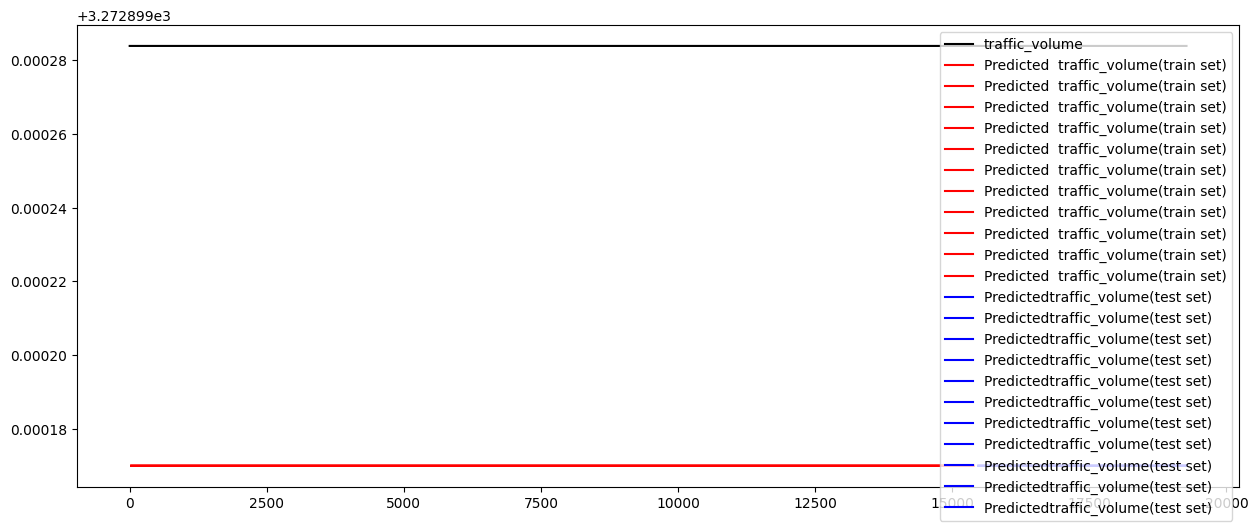

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"traffic_volume")
plt.plot(trainPredictPlot, color='red', label=f"Predicted  traffic_volume(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predictedtraffic_volume(test set)")
plt.legend()

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

## Project Questions: 1. **Data Preprocessing**: Explain how you chose data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data to train the model?
In the first 4 code I converted time to time instead of object and then cleaned the data
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the prediction model.
I did more than one feature for the week, day, and month

3. **Model Engineering**: Describe the logic behind your model engineering (e.g., model type, layers, number of neurons, activation functions). Why do you think this architecture is appropriate for time series forecasting?
In the code I added more than one layer with drops to save time
4. **Training Process**: Discuss why you chose the batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you try different values, and what were the results?
Here is a Madwell that is not satisfied with learning. Come on, I am rare.
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the prediction goal?

mean_squared_error is best
6. **Model Tuning (if done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve the model’s performance?
7. **Overfitting and Underfitting**: Analyze whether the model experienced any overfitting or underfitting during training. What strategies can you implement to mitigate these issues?
In Sklare, Outliers, and Madwell Training
8. **Future Improvements**: Suggest potential improvements or other steps you can take to improve the model’s performance. Consider using different algorithms, feature engineering techniques, or hyperparameter tuning.
Improve from Madwell Learning